In [16]:
from keras import optimizers
import tensorflow as tf
import efficientnet.tfkeras as efn
from keras.models import Model, load_model
from keras.layers import Dense, GlobalAveragePooling2D, Dropout
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint
from keras.callbacks import TensorBoard

In [17]:
# 0 : VGG16
# 1 : ResNet50
# 2 : EfficientNet_B2
CNN_name = ['VGG16', 'ResNet50', 'EfficientNet_B2']

In [18]:
CNN_Serial_number = 1

In [19]:
# NB_CLASSL: number of classes
NB_CLASS = 5

In [20]:
# Whether to perform data augmentation. 0 does not extend data. 1 Extended data
augmentation_name = ['No_Aug', 'Aug']
augmentation = 0

In [21]:
# According to the machine memory
batch_size = 32

In [22]:
# Total training rounds
EPOCH = 25

In [23]:
IMG_WIDTH = 224
IMG_HEIGHT = 224

In [24]:
train_root = './dataset-Simpsons_Main_Characters/train_images/'
validation_root = './dataset-Simpsons_Main_Characters/test_images/'

In [25]:
# log display level
verbose = 1

In [26]:
# loss function
loss = tf.keras.losses.categorical_crossentropy

In [27]:
# optimize function
# RMSprop
# optimizer = optimizers.RMSprop(learning_rate=0.001, rho=0.9, epsilon=None, decay=0.0)

# Adam
# optimizer = optimizers.adam.Adam(learning_rate=0.001, beta_1=0.9, beta_2 = 0.999, epsilon=None, amsgrad = False)
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5)

In [28]:
# Data processing
My_ImageDatagenerator = ImageDataGenerator(
    width_shift_range=0.1, 
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    rescale=1. / 255,
)

In [29]:
train_generator = My_ImageDatagenerator.flow_from_directory(
    train_root,
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=batch_size,
    shuffle=True
)
valid_generator = My_ImageDatagenerator.flow_from_directory(
    validation_root,
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=batch_size,
)

Found 6936 images belonging to 5 classes.
Found 404 images belonging to 5 classes.


In [30]:
import keras.applications as cnn_model
if CNN_Serial_number == 0:
    base_model = cnn_model.vgg16.VGG16(weights='./pretrained/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5', include_top=False)
elif CNN_Serial_number == 1:
    base_model = cnn_model.resnet.ResNet50(weights='./pretrained/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5', include_top=False)
elif CNN_Serial_number == 2:
    base_model = efn.EfficientNetB2(weights='./pretrained/efficientnet-b2_weights_tf_dim_ordering_tf_kernels_autoaugment_notop.h5', include_top=False)
    
    
    

In [31]:
#Add global average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)


In [32]:
# add a fully connected layer
x = Dense(256, activation='relu')(x)

In [33]:
# add a classifier
predictions = Dense(NB_CLASS, activation='softmax')(x)

In [34]:
#Build the complete model we need to train

model = Model(inputs=base_model.input, outputs=predictions)

In [35]:
# Migration learning, only train the last 10 layers
for layer in model.layers:
    layer.trainable = False
for i in range(-10, 0):
    model.layers[i].trainable = True

In [36]:
from keras import metrics

In [37]:
# Compile the model
model.compile(optimizer=optimizer, loss=loss, metrics=['acc', metrics.Precision(), metrics.Recall()])

In [38]:
# print model structure
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, None, None,   0           ['input_2[0][0]']                
                                3)                                                                
                                                                                                  
 conv1_conv (Conv2D)            (None, None, None,   9472        ['conv1_pad[0][0]']              
                                64)                                                           

                                                                                                  
 conv2_block2_add (Add)         (None, None, None,   0           ['conv2_block1_out[0][0]',       
                                256)                              'conv2_block2_3_bn[0][0]']      
                                                                                                  
 conv2_block2_out (Activation)  (None, None, None,   0           ['conv2_block2_add[0][0]']       
                                256)                                                              
                                                                                                  
 conv2_block3_1_conv (Conv2D)   (None, None, None,   16448       ['conv2_block2_out[0][0]']       
                                64)                                                               
                                                                                                  
 conv2_blo

                                128)                                                              
                                                                                                  
 conv3_block2_2_bn (BatchNormal  (None, None, None,   512        ['conv3_block2_2_conv[0][0]']    
 ization)                       128)                                                              
                                                                                                  
 conv3_block2_2_relu (Activatio  (None, None, None,   0          ['conv3_block2_2_bn[0][0]']      
 n)                             128)                                                              
                                                                                                  
 conv3_block2_3_conv (Conv2D)   (None, None, None,   66048       ['conv3_block2_2_relu[0][0]']    
                                512)                                                              
          

 conv4_block1_1_bn (BatchNormal  (None, None, None,   1024       ['conv4_block1_1_conv[0][0]']    
 ization)                       256)                                                              
                                                                                                  
 conv4_block1_1_relu (Activatio  (None, None, None,   0          ['conv4_block1_1_bn[0][0]']      
 n)                             256)                                                              
                                                                                                  
 conv4_block1_2_conv (Conv2D)   (None, None, None,   590080      ['conv4_block1_1_relu[0][0]']    
                                256)                                                              
                                                                                                  
 conv4_block1_2_bn (BatchNormal  (None, None, None,   1024       ['conv4_block1_2_conv[0][0]']    
 ization) 

                                                                                                  
 conv4_block3_3_bn (BatchNormal  (None, None, None,   4096       ['conv4_block3_3_conv[0][0]']    
 ization)                       1024)                                                             
                                                                                                  
 conv4_block3_add (Add)         (None, None, None,   0           ['conv4_block2_out[0][0]',       
                                1024)                             'conv4_block3_3_bn[0][0]']      
                                                                                                  
 conv4_block3_out (Activation)  (None, None, None,   0           ['conv4_block3_add[0][0]']       
                                1024)                                                             
                                                                                                  
 conv4_blo

 ization)                       256)                                                              
                                                                                                  
 conv4_block6_2_relu (Activatio  (None, None, None,   0          ['conv4_block6_2_bn[0][0]']      
 n)                             256)                                                              
                                                                                                  
 conv4_block6_3_conv (Conv2D)   (None, None, None,   263168      ['conv4_block6_2_relu[0][0]']    
                                1024)                                                             
                                                                                                  
 conv4_block6_3_bn (BatchNormal  (None, None, None,   4096       ['conv4_block6_3_conv[0][0]']    
 ization)                       1024)                                                             
          

 conv5_block3_1_conv (Conv2D)   (None, None, None,   1049088     ['conv5_block2_out[0][0]']       
                                512)                                                              
                                                                                                  
 conv5_block3_1_bn (BatchNormal  (None, None, None,   2048       ['conv5_block3_1_conv[0][0]']    
 ization)                       512)                                                              
                                                                                                  
 conv5_block3_1_relu (Activatio  (None, None, None,   0          ['conv5_block3_1_bn[0][0]']      
 n)                             512)                                                              
                                                                                                  
 conv5_block3_2_conv (Conv2D)   (None, None, None,   2359808     ['conv5_block3_1_relu[0][0]']    
          

In [39]:
import time
# log storage path
now = int(time.time())
timeArray = time.localtime(now)
otherStyleTime = time.strftime("%Y-%m-%d-%H-%M-%S", timeArray)
log_dir = './logs/' + CNN_name[CNN_Serial_number] + '_'+augmentation_name[augmentation]+'_'+otherStyleTime


In [40]:
tbCallBack = TensorBoard(log_dir=log_dir, histogram_freq=1, update_freq="epoch", )

In [41]:
#Save path of optimal model
filePath = './' + CNN_name[CNN_Serial_number] + '_'+augmentation_name[augmentation]+'_best.h5'


In [42]:
#If there is an upgrade, it will be overwritten once
checkpoint = ModelCheckpoint(filePath, monitor='val_acc', verbose=1, save_best_only=True, mode='max', save_freq='epoch')



In [43]:
callbacks_list = [checkpoint, tbCallBack]


In [44]:
# train on the dataset
history = model.fit(train_generator, 
                    validation_data=valid_generator,
                    epochs=EPOCH,
                    steps_per_epoch=train_generator.n / batch_size,
                    validation_steps=valid_generator.n / batch_size,
                    verbose = verbose,
                    callbacks = callbacks_list)

Epoch 1/25


2023-05-01 21:38:29.380001: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


217/216 [==============================] - ETA: 0s - loss: 1.5155 - acc: 0.3276 - precision: 0.7013 - recall: 0.0156

2023-05-01 21:45:19.859095: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]



Epoch 1: val_acc improved from -inf to 0.20050, saving model to ./ResNet50_No_Aug_best.h5
216/216 [==============================] - 438s 2s/step - loss: 1.5155 - acc: 0.3276 - precision: 0.7013 - recall: 0.0156 - val_loss: 1.6573 - val_acc: 0.2005 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/25
217/216 [==============================] - ETA: 0s - loss: 1.4384 - acc: 0.3899 - precision: 0.7371 - recall: 0.0473
Epoch 2: val_acc improved from 0.20050 to 0.27970, saving model to ./ResNet50_No_Aug_best.h5
216/216 [==============================] - 433s 2s/step - loss: 1.4384 - acc: 0.3899 - precision: 0.7371 - recall: 0.0473 - val_loss: 1.5861 - val_acc: 0.2797 - val_precision: 0.7059 - val_recall: 0.0297
Epoch 3/25
217/216 [==============================] - ETA: 0s - loss: 1.3743 - acc: 0.4501 - precision: 0.7530 - recall: 0.0826
Epoch 3: val_acc did not improve from 0.27970
216/216 [==============================] - 432s 2s/step - loss: 1.3743 - acc: 0.4501 - precision: 

Epoch 22/25
217/216 [==============================] - ETA: -2s - loss: 0.8733 - acc: 0.6772 - precision: 0.8170 - recall: 0.5123
Epoch 22: val_acc did not improve from 0.48267
216/216 [==============================] - 2638s 12s/step - loss: 0.8733 - acc: 0.6772 - precision: 0.8170 - recall: 0.5123 - val_loss: 1.7026 - val_acc: 0.3589 - val_precision: 0.4232 - val_recall: 0.3069
Epoch 23/25
217/216 [==============================] - ETA: -3s - loss: 0.8710 - acc: 0.6775 - precision: 0.8034 - recall: 0.5177
Epoch 23: val_acc did not improve from 0.48267
216/216 [==============================] - 3307s 15s/step - loss: 0.8710 - acc: 0.6775 - precision: 0.8034 - recall: 0.5177 - val_loss: 1.5836 - val_acc: 0.3837 - val_precision: 0.4704 - val_recall: 0.3144
Epoch 24/25
217/216 [==============================] - ETA: -6s - loss: 0.8563 - acc: 0.6866 - precision: 0.8153 - recall: 0.5309
Epoch 24: val_acc did not improve from 0.48267
216/216 [==============================] - 5422s 25s/step

In [45]:
trained_filePath = './p_trained/' + CNN_name[CNN_Serial_number] + '_'+augmentation_name[augmentation]+'_'+otherStyleTime+'_best.h5'


In [46]:
from joblib import Parallel, delayed
import joblib


# Save the model as a pickle in a file
joblib.dump(model, trained_filePath)

['./p_trained/ResNet50_No_Aug_2023-05-01-21-38-23_best.h5']

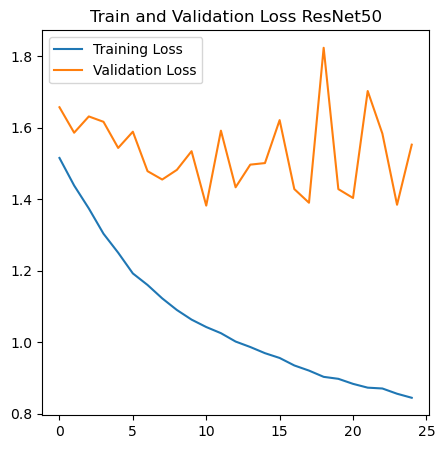

In [49]:
import matplotlib.pyplot as plt
import numpy as np
# Visualization of Accuracy and loss
# Loss
train_loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCH)

plt.figure(figsize=(5, 5))
plt.plot(epochs_range, train_loss, label="Training Loss")
plt.plot(epochs_range, val_loss, label="Validation Loss")
plt.legend(loc='upper left')
plt.title('Train and Validation Loss ' + CNN_name[CNN_Serial_number])

plt.show()

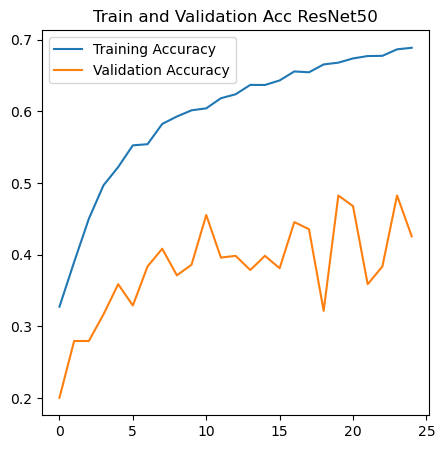

In [50]:
# Accuracy
train_acc = history.history['acc']
val_acc = history.history['val_acc']

epochs_range = range(EPOCH)

plt.figure(figsize=(5, 5))
plt.plot(epochs_range, train_acc, label="Training Accuracy")
plt.plot(epochs_range, val_acc, label="Validation Accuracy")
plt.legend(loc='upper left')
plt.title('Train and Validation Acc ' + CNN_name[CNN_Serial_number])

plt.show()

In [51]:
# Image test

test_root = './test/'
# Load the model from the file
from_model = joblib.load(trained_filePath)
test_datagen = ImageDataGenerator(
    rescale=1. / 255
)
test_genertor = test_datagen.flow_from_directory(
    test_root,
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=batch_size,
)

result = from_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc', metrics.Precision(), metrics.Recall()])



Found 5 images belonging to 5 classes.


In [52]:
model.evaluate(test_genertor, 
               max_queue_size=10, workers=1, use_multiprocessing=False, verbose=verbose)



2023-05-02 08:49:21.766955: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


1/1 [==============================] - 0s 336ms/step - loss: 4.2557 - acc: 0.4000 - precision: 0.4000 - recall: 0.4000


[4.255724906921387, 0.4000000059604645, 0.4000000059604645, 0.4000000059604645]

In [53]:
print(type(test_genertor.n / batch_size))
print(test_genertor.n / batch_size)

<class 'float'>
0.15625


In [54]:
# confusion matrix
display_labels = range(0, NB_CLASS)

In [55]:
show_figure = False
normalization = True

In [56]:
def test(picname, model):
    keras.backend.clear_session()
    img_path = picname
    test_image = image.load_img(img_path, target_size=(IMG_WIDTH, IMG_HEIGHT))
    test_image = image.img_to_array(test_image)
    test_image = np.expand_dims(test_image, axis=0)
    test_image_test_image/255
    predict = model.predict(tesy_image)
    preds = np.argmax(predict, axis=1)[0]
    return preds

In [58]:
test_gen = test_datagen.flow_from_directory(test_root, target_size=(IMG_WIDTH, IMG_HEIGHT))
print(test_gen.class_indices)

Found 5 images belonging to 5 classes.
{'bart_simpson': 0, 'homer_simpson': 1, 'lisa_simpson': 2, 'maggie_simpson': 3, 'marge_simpson': 4}


min: 0.0 max: 0.96470594


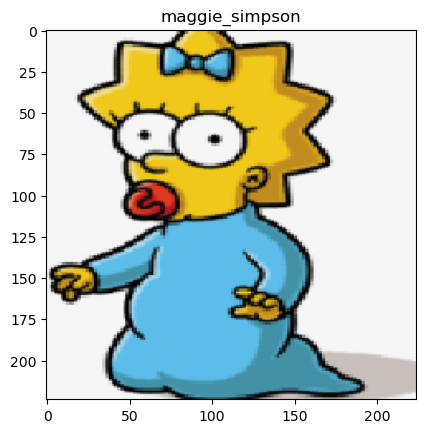

['bart_simpson', 'homer_simpson', 'lisa_simpson', 'maggie_simpson', 'marge_simpson']


In [59]:
labels = [None] * len(test_gen.class_indices)
for k, v in test_gen.class_indices.items():
    labels[v] = k

# should be a strangely colored image (due to VGG weights being BGR)
for x, y in test_gen:
    print("min:", x[0].min(), "max:", x[0].max())
    plt.title(labels[np.argmax(y[0])])
    plt.imshow(x[0])
    plt.show()
    break
print(labels)

In [60]:
import itertools


def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    plt.rcParams["figure.figsize"] = (40,20)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
               horizontalalignment="center",
               color="white" if cm[i, j] > thresh else "black")
  
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

In [61]:
from glob import glob

# useful for getting number of files
image_files = glob(train_root + '/*/*.jp*g')
test_image_files = glob(test_root + '/*/*.jp*g')

# useful for getting number of classes
folders = glob(train_root + '/*')
print(folders)

['./dataset-Simpsons_Main_Characters/train_images/maggie_simpson', './dataset-Simpsons_Main_Characters/train_images/marge_simpson', './dataset-Simpsons_Main_Characters/train_images/bart_simpson', './dataset-Simpsons_Main_Characters/train_images/lisa_simpson', './dataset-Simpsons_Main_Characters/train_images/homer_simpson']


In [62]:
import os
import json
import glob
from prettytable import PrettyTable





class ConfusionMatrix(object):
    def __init__(self, num_classes: int, labels: list):
        self.matrix = np.zeros((num_classes, num_classes))
        self.num_classes = num_classes
        self.labels = labels

    def update(self, preds, labels):
        for p, t in zip(preds, labels):
            self.matrix[p, t] += 1

    def summary(self):
        # calculate accuracy
        sum_TP = 0
        for i in range(self.num_classes):
            sum_TP += self.matrix[i, i]
        acc = sum_TP / np.sum(self.matrix)
        print("the model accuracy is ", acc)

        # precision, recall, specificity
        table = PrettyTable()
        table.field_names = ["", "Precision", "Recall", "Specificity", 'F1']
        for i in range(self.num_classes):
            TP = self.matrix[i, i]
            FP = np.sum(self.matrix[i, :]) - TP
            FN = np.sum(self.matrix[:, i]) - TP
            TN = np.sum(self.matrix) - TP - FP - FN
            Precision = round(TP / (TP + FP), 3) if TP + FP != 0 else 0.
            Recall = round(TP / (TP + FN), 3) if TP + FN != 0 else 0.
            Specificity = round(TN / (TN + FP), 3) if TN + FP != 0 else 0.
            F1 = round(2*Precision*Recall/(Precision+Recall), 3) if Precision+Recall != 0 else 0.
            table.add_row([self.labels[i], Precision, Recall, Specificity, F1])
        print(table)

    def plot(self):
        matrix = self.matrix
        print(matrix)
        plt.imshow(matrix, cmap=plt.cm.Blues)

        plt.xticks(range(self.num_classes), self.labels, rotation=45)
        plt.yticks(range(self.num_classes), self.labels)
        plt.colorbar()
        plt.xlabel('True Labels')
        plt.ylabel('Predicted Labels')
        plt.title('Confusion matrix')

        thresh = matrix.max() / 2
        for x in range(self.num_classes):
            for y in range(self.num_classes):
                info = int(matrix[y, x])
                plt.text(x, y, info,
                         verticalalignment='center',
                         horizontalalignment='center',
                         color="white" if info > thresh else "black")
        plt.tight_layout()
        plt.show()


Found 404 images belonging to 5 classes.


  0%|                                                    | 0/13 [00:00<?, ?it/s]2023-05-01 18:32:30.653347: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype float and shape [32,224,224,3]
	 [[{{node Placeholder/_0}}]]
  8%|███▍                                        | 1/13 [00:02<00:25,  2.11s/it]2023-05-01 18:32:32.722376: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype float and shape [32,224,224,3]
	 [[{{node Placeholder/_0}}]]
 15%|██████▊                                     | 2/13 [00:03<00:21,  1.98s/it]2023-05-01 18:32:34.572668: I tensorflow/core/common_runti

[[69.  0.  2.  4.  9.]
 [ 8. 80.  5. 10. 15.]
 [ 2.  0. 64. 48.  5.]
 [ 2.  0.  7. 15.  0.]
 [ 0.  1.  2.  4. 52.]]


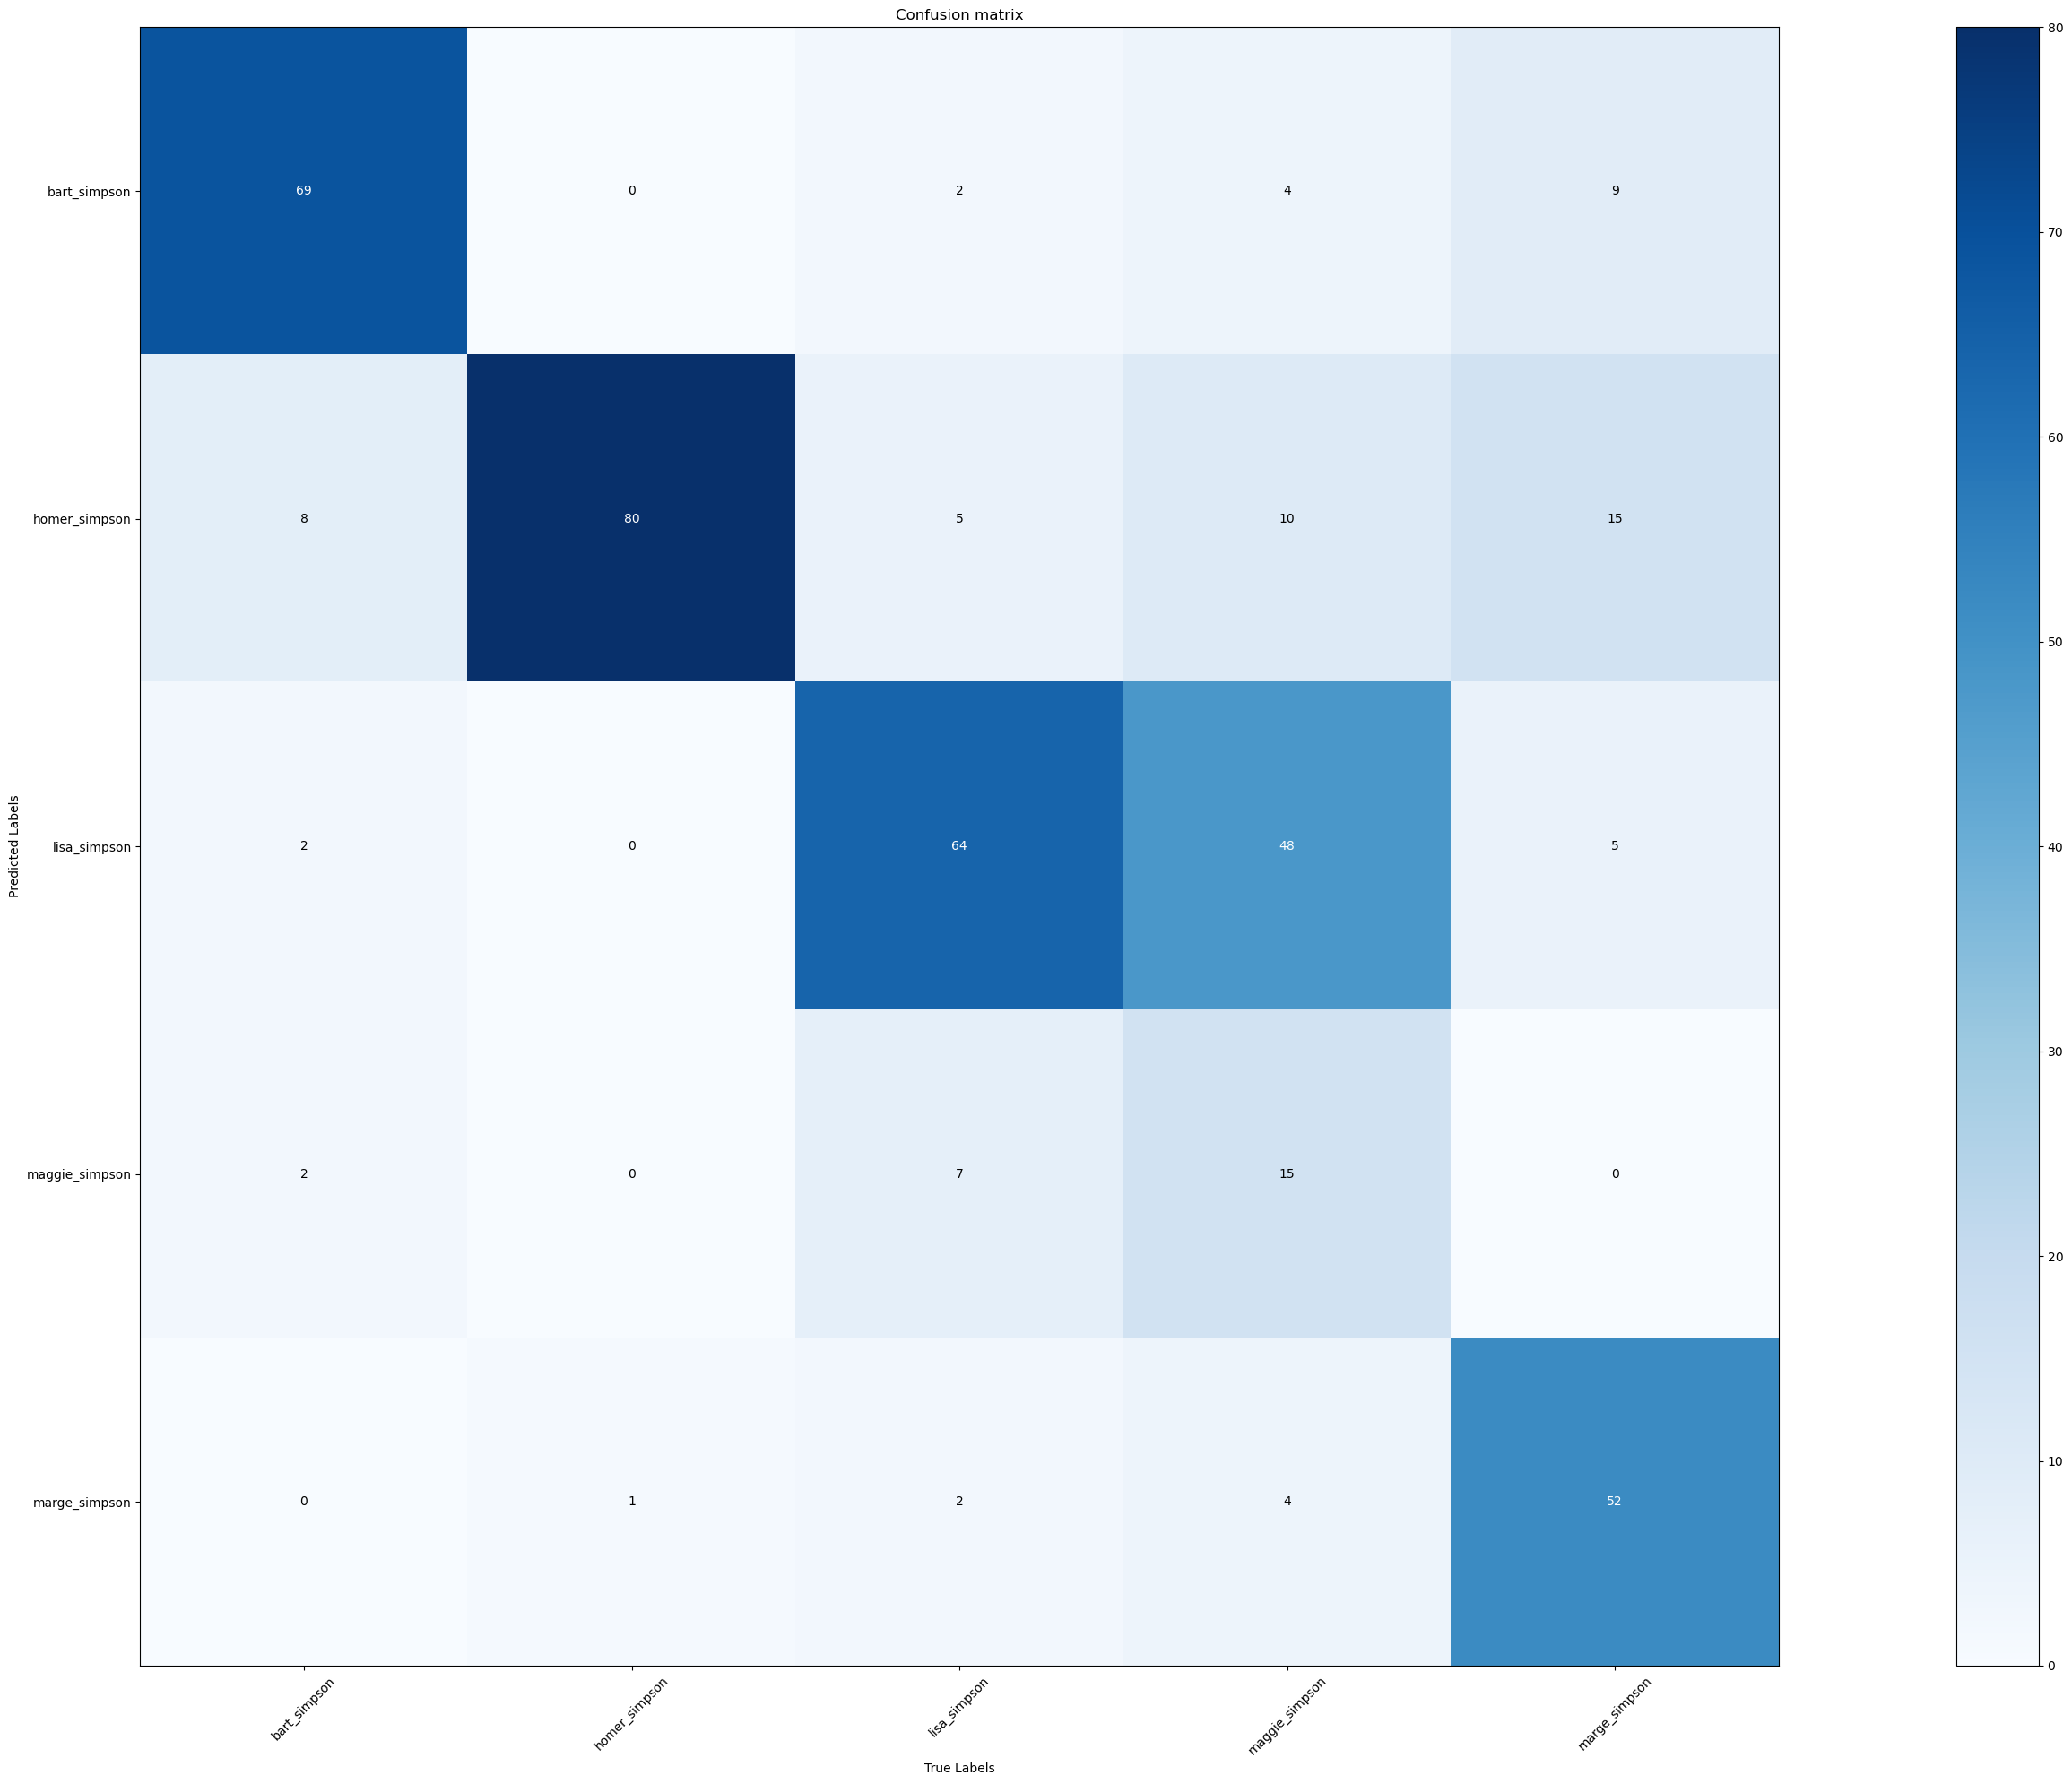

the model accuracy is  0.693069306930693
+----------------+-----------+--------+-------------+-------+
|                | Precision | Recall | Specificity |   F1  |
+----------------+-----------+--------+-------------+-------+
|  bart_simpson  |   0.821   | 0.852  |    0.954    | 0.836 |
| homer_simpson  |   0.678   | 0.988  |    0.882    | 0.804 |
|  lisa_simpson  |   0.538   |  0.8   |     0.83    | 0.643 |
| maggie_simpson |   0.625   | 0.185  |    0.972    | 0.285 |
| marge_simpson  |   0.881   | 0.642  |    0.978    | 0.743 |
+----------------+-----------+--------+-------------+-------+


In [367]:

from tqdm import tqdm
def pre_function(img):
    # img = im.open('test.jpg')
    # img = np.array(img).astype(np.float32)
    img = img / 255.
    img = (img - 0.5) * 2.0
    return img


# data generator with data augmentation
validation_image_generator = ImageDataGenerator(preprocessing_function=pre_function)

val_data_gen = validation_image_generator.flow_from_directory(directory=validation_root,
                                                              batch_size=batch_size,
                                                              shuffle=False,
                                                              target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                              class_mode='categorical')
# img, _ = next(train_data_gen)
total_val = val_data_gen.n
confusion = ConfusionMatrix(num_classes=NB_CLASS, labels=labels)

# validate
for step in tqdm(range(math.ceil(total_val / batch_size))):
    val_images, val_labels = next(val_data_gen)
    results = from_model.predict_on_batch(val_images)
    results = tf.keras.layers.Softmax()(results).numpy()
    results = np.argmax(results, axis=-1)
    labels1 = np.argmax(val_labels, axis=-1)
    confusion.update(results, labels1)
confusion.plot()
confusion.summary()

In [360]:
print(NB_CLASS)
print(labels)
print(len(labels))

5
['bart_simpson', 'homer_simpson', 'lisa_simpson', 'maggie_simpson', 'marge_simpson']
5
